## Getting Started
First generating some test data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from annotation_driven_dataframe_calcs.annotation_driven_dataframe_calcs import expand_for_timesteps
from annotation_driven_dataframe_calcs.column_names import TIMESTEP_NO, ACCOUNT_NO, PARAM_C, PARAM_B, PARAM_A

fake_data = pd.DataFrame({
    ACCOUNT_NO: [1, 2, 3, 4],
    PARAM_A: [201908, 201907, 201906, 201905],
    PARAM_B: [10, 15, 20, 25],
    PARAM_C: [5, 6, 7, 8]
})

2020-12-16 01:57:16.182 | DEBUG    | annotation_driven_dataframe_calcs.registry:<module>:11 - Creating the registry
2020-12-16 01:57:16.183 | DEBUG    | annotation_driven_dataframe_calcs.registry:<module>:13 - Registry created
2020-12-16 01:57:16.186 | DEBUG    | annotation_driven_dataframe_calcs.registry:register:32 - Registering series SERIES_A_PRIME and its dependencies []
2020-12-16 01:57:16.187 | DEBUG    | annotation_driven_dataframe_calcs.registry:register:32 - Registering series TEST_OUTPUT_C and its dependencies []
2020-12-16 01:57:16.189 | DEBUG    | annotation_driven_dataframe_calcs.registry:register:32 - Registering series SERIES_A_PRIME_FROM_DECS and its dependencies []


In [3]:
result = expand_for_timesteps(fake_data, 1, 3)
result

COLUMN_A  COLUMN_B  COLUMN_C
ACCT_NO TIMESTEP_NO                              
1       1              201908        10         5
        2              201908        10         5
        3              201908        10         5
2       1              201907        15         6
        2              201907        15         6
        3              201907        15         6
3       1              201906        20         7
        2              201906        20         7
        3              201906        20         7
4       1              201905        25         8
        2              201905        25         8
        3              201905        25         8

2020-12-16 01:57:33.849 | DEBUG    | annotation_driven_dataframe_calcs.annotation_driven_dataframe_calcs:join_registered_series_values:44 - the registered series and handlers are: ['SERIES_A_PRIME_FROM_DECS', 'TEST_OUTPUT_C', 'SERIES_A_PRIME']
2020-12-16 01:57:33.851 | INFO     | annotation_driven_dataframe_calcs.annotation_driven_dataframe_calcs:join_registered_series_values:46 - The task graph of the relationships between series shows:

2020-12-16 01:57:33.908 | INFO     | annotation_driven_dataframe_calcs.annotation_driven_dataframe_calcs:join_registered_series_values:51 - The task graph of the relationships has been saved to /home/noce2/development/workspaces/noce2/annotation_driven_dataframe_calcs/notebooks/param_calc_task_graph.png:

2020-12-16 01:57:33.909 | DEBUG    | annotation_driven_dataframe_calcs.annotation_driven_dataframe_calcs:__calculate_series_and_merge_with_df:64 - calculating the series SERIES_A_PRIME_FROM_DECS
2020-12-16 01:57:33.912 | DEBUG    | annotation_driven_

COLUMN_A  COLUMN_B  COLUMN_C  SERIES_A_PRIME_FROM_DECS  \
ACCT_NO TIMESTEP_NO                                                           
1       1              201908        10         5                     100.0   
        2              201908        10         5                      85.0   
        3              201908        10         5                      70.0   
2       1              201907        15         6                     100.0   
        2              201907        15         6                      79.0   
        3              201907        15         6                      58.0   
3       1              201906        20         7                     100.0   
        2              201906        20         7                      73.0   
        3              201906        20         7                      46.0   
4       1              201905        25         8                     100.0   
        2              201905        25         8                      67.0   
        3              201905        25         8                      34.0   

                     TEST_OUTPUT_C  SERIES_A_PRIME  
ACCT_NO TIMESTEP_NO                                 
1       1                    -15.0           100.0  
        2                    -15.0            85.0  
        3                    -15.0            70.0  
2       1                    -21.0           100.0  
        2                    -21.0            79.0  
        3                    -21.0            58.0  
3       1                    -27.0           100.0  
        2                    -27.0            73.0  
        3                    -27.0            46.0  
4       1                    -33.0           100.0  
        2                    -33.0            67.0  
        3                    -33.0            34.0

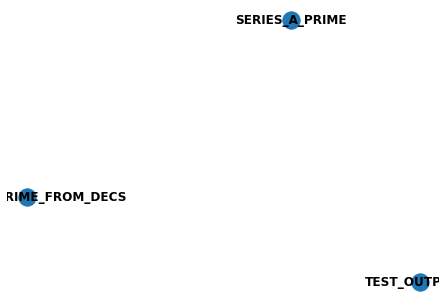

In [4]:
from annotation_driven_dataframe_calcs.annotation_driven_dataframe_calcs import join_registered_series_values

enhanced_result = join_registered_series_values(result)

enhanced_result